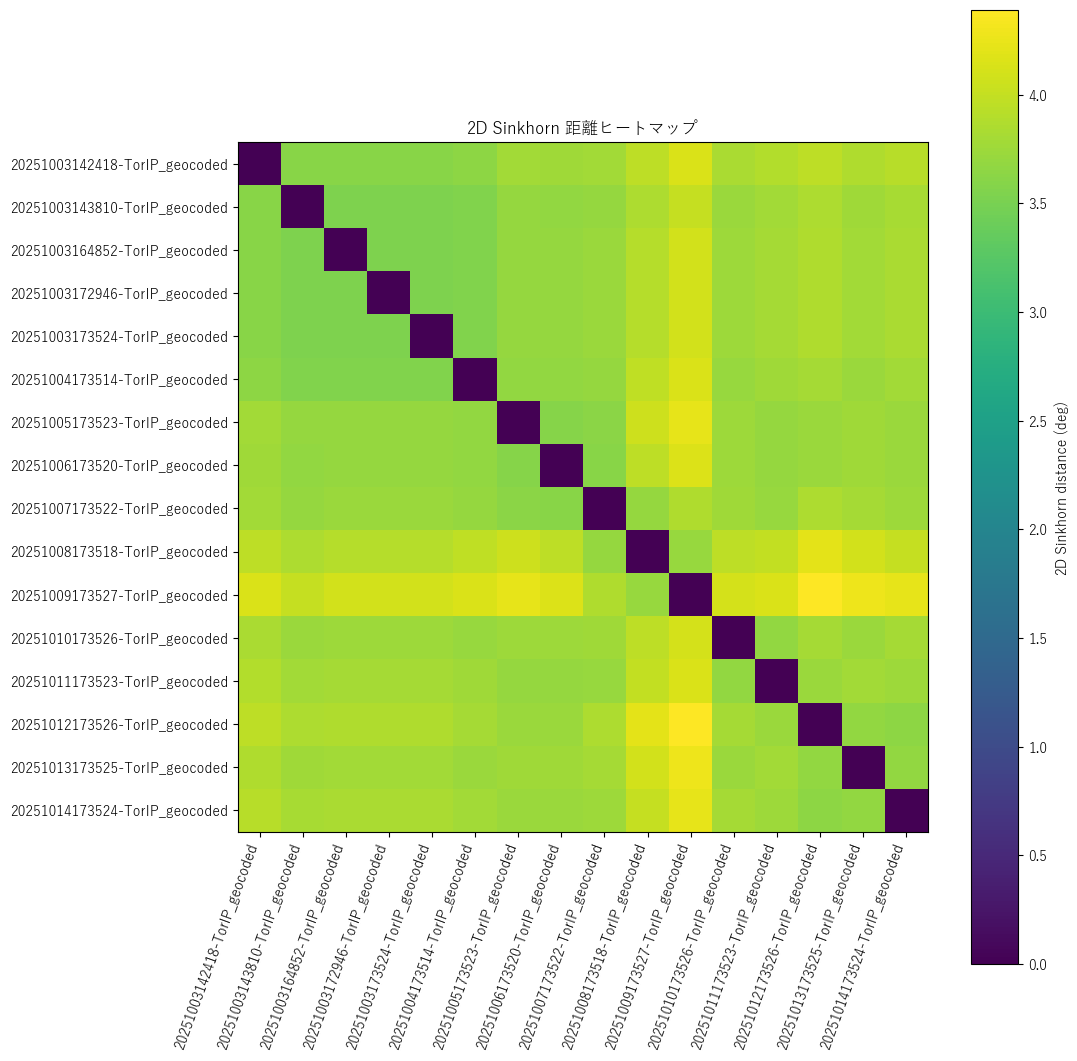

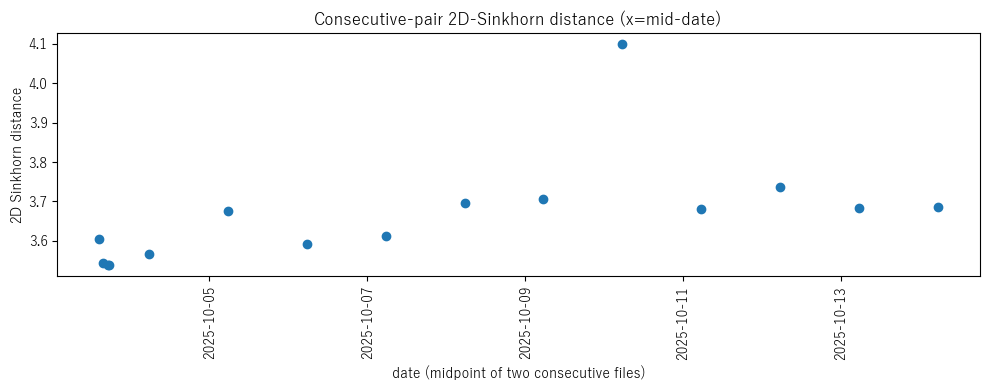

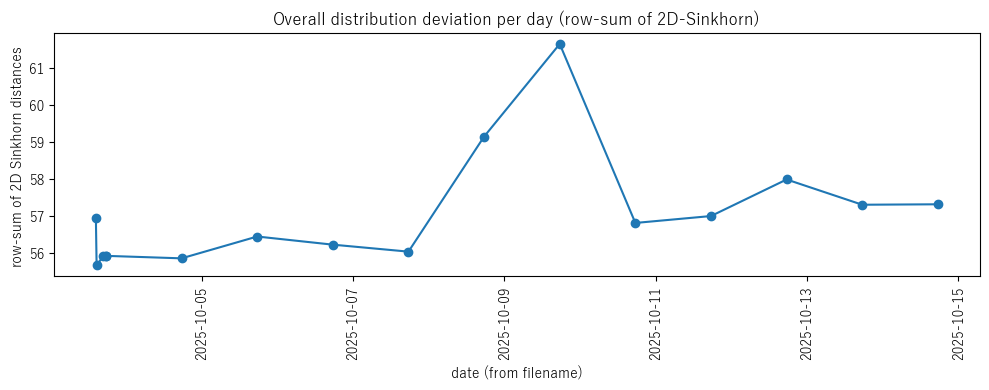

✅ 出力完了（Sinkhorn距離）
   sinkhorn_matrix.csv
   sinkhorn_files.txt
   sinkhorn_timeseries.csv
   sinkhorn_heatmap.png
   sinkhorn_timeseries.png
   sinkhorn_row_sums.png


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Sinkhorn 距離（エントロピー正則化OT）版
- isolation_forest.zip を自動解凍して *-TorIP_geocoded.csv を処理
- (1) 全ファイル間 2D-Sinkhorn 距離行列 (CSV/PNG)
- (2) 隣接ペア 2D-Sinkhorn 時系列 (CSV/PNG)
- (3) 距離行列の行総和（総乖離度）(PNG)

※ 2Dは lat/lon を同一グリッド上で確率化し、セル中心間の距離をOTコストに採用
※ seaborn 不使用（matplotlib のみ）、CSVは cp932（必要なら utf-8-sig へ変更）
"""

# ========= 設定 =========
ZIP_PATH        = "./isolation_forest.zip"
EXTRACT_DIR     = "./isolation_forest_extracted"
PREFIX          = "sinkhorn"    # 出力プレフィックス
UNIT            = "deg"         # "deg" or "km"
MIN_ROWS        = 1
Z_THR_TS        = 3.5
OUTPUT_ENCODING = "cp932"       # Excel重視（utf-8-sig でもOK）

# 2Dヒスト推定（pooledレンジ推奨）
BINS_LAT    = 48                # 32〜64程度（大きくすると精細・計算増）
BINS_LON    = 48
RANGE_MODE  = "pooled"          # "pooled"（全データで共有レンジ）/ "pair"
EPS_SMOOTH  = 1e-12             # ゼロ頻度の平滑化

# Sinkhorn（エントロピー正則化OT）
SINKHORN_EPS     = 5.0          # 正則化強度（kmなら 5~50 目安、degなら 0.05~0.5 目安）
SINKHORN_MAX_ITR = 500
SINKHORN_TOL     = 1e-6
# =======================

import os, sys, csv, math, zipfile, shutil
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib import font_manager, rcParams

# ---------- フォント ----------
JP_FONT_CANDIDATES = ["Yu Gothic", "Meiryo", "Noto Sans CJK JP", "IPAexGothic", "IPAPGothic", "TakaoGothic"]
def setup_japanese_font():
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in JP_FONT_CANDIDATES:
        if name in available:
            rcParams["font.family"] = "sans-serif"
            rcParams["font.sans-serif"] = [name]
            break
    rcParams["axes.unicode_minus"] = False

# ---------- 文字コード ----------
READ_ENCODINGS = ("utf-8", "utf-8-sig", "cp932", "iso-8859-1")
def open_read_fallback(path):
    last = None
    for enc in READ_ENCODINGS:
        try:
            return open(path, "r", encoding=enc, newline="")
        except Exception as e:
            last = e
    try:
        return open(path, "r", newline="")
    except Exception:
        raise last or RuntimeError(f"cannot open {path}")

TRANSLATE_TABLE = {
    0x2010: ord("-"), 0x2011: ord("-"), 0x2012: ord("-"), 0x2013: ord("-"),
    0x2014: ord("-"), 0x2015: ord("-"), 0x2212: ord("-"),
    0x00A0: ord(" ")
}
def normalize_text(s: str) -> str:
    return s.translate(TRANSLATE_TABLE) if isinstance(s, str) else s

def open_write(path):
    return open(path, "w", encoding=OUTPUT_ENCODING, newline="", errors="replace")

# ---------- CSV 読み込み ----------
def row_has_header_like(cells):
    if len(cells) < 4: return True
    try:
        float((cells[2] or "").strip()); float((cells[3] or "").strip())
        return False
    except Exception:
        return True

def load_valid_latlon(filepath):
    lats, lons = [], []
    with open_read_fallback(filepath) as f:
        rdr = csv.reader(f)
        first = next(rdr, None)
        if first is None: return np.empty(0), np.empty(0)
        use_header = row_has_header_like(first)
        rows_iter = rdr if use_header else [first] + list(rdr)
        for row in rows_iter:
            if len(row) < 4: continue
            a = (row[2] or "").strip(); b = (row[3] or "").strip()
            if not a or not b: continue
            try:
                lat = float(a); lon = float(b)
                if math.isfinite(lat) and math.isfinite(lon):
                    lats.append(lat); lons.append(lon)
            except Exception:
                continue
    return np.array(lats, float), np.array(lons, float)

# ---------- 単位換算 ----------
def deg_to_km_scale(lat_values):
    phi = (float(np.median(lat_values)) if len(lat_values) else 0.0) * math.pi/180.0
    return 111.32, 111.32 * math.cos(phi)

def convert_unit(lat_array, lon_array, ref_lat=None):
    if UNIT != "km":
        return lat_array, lon_array
    ref = ref_lat if ref_lat is not None else (np.median(lat_array) if len(lat_array) else 0.0)
    la_km, lo_km = deg_to_km_scale(np.array([ref]))
    return lat_array * la_km, lon_array * lo_km

# ---------- 2Dヒスト + 座標 ----------
def hist2d_prob_and_coords(lat, lon, bins_lat, bins_lon, r_lat, r_lon):
    # 2Dヒスト（counts）→ 平滑化 → 確率化
    H, lat_edges, lon_edges = np.histogram2d(lat, lon, bins=[bins_lat, bins_lon],
                                             range=[r_lat, r_lon], density=False)
    H = H.astype(float) + EPS_SMOOTH
    H /= H.sum()

    # セル中心座標（同次元の距離をコストに）
    lat_centers = 0.5 * (lat_edges[:-1] + lat_edges[1:])
    lon_centers = 0.5 * (lon_edges[:-1] + lon_edges[1:])
    L, G = np.meshgrid(lat_centers, lon_centers, indexing="ij")
    coords = np.stack([L.ravel(), G.ravel()], axis=1)  # (Ncells, 2)
    return H.ravel(), coords  # (N,), (N,2)

def pad_range(x):
    if x is None or x.size == 0: return (-1.0, 1.0)
    lo, hi = float(np.min(x)), float(np.max(x))
    if lo == hi:
        span = 1.0 if lo == 0 else abs(lo)*0.01
        lo -= span; hi += span
    pad = (hi - lo) * 0.02
    return (lo - pad, hi + pad)

# ---------- Sinkhorn 実装（簡易/密行列; NumPy版） ----------
def pairwise_euclidean(a, b):
    # a:(N,2), b:(M,2) -> (N,M)
    ax = a[:, 0][:, None]; ay = a[:, 1][:, None]
    bx = b[:, 0][None, :]; by = b[:, 1][None, :]
    return np.sqrt((ax - bx)**2 + (ay - by)**2)

def sinkhorn_distance(a_prob, b_prob, coords, epsilon=SINKHORN_EPS,
                      max_iter=SINKHORN_MAX_ITR, tol=SINKHORN_TOL):
    """
    a_prob, b_prob: shape (N,) の確率ベクトル（sum=1）
    coords       : shape (N,2) のセル中心座標（同一グリッドであること）
    """
    # 同一グリッド前提なのでCは (N,N) 対称
    C = pairwise_euclidean(coords, coords)  # 地理距離（UNITに合わせた尺度）
    # 安定化のためスケーリング（桁が大きい場合）
    eps = float(epsilon)
    K = np.exp(-C / max(eps, 1e-12)) + 1e-300  # underflow回避の微小値
    u = np.ones_like(a_prob)
    v = np.ones_like(b_prob)
    # 反復（Sinkhorn-Knopp）
    for it in range(max_iter):
        u_prev = u
        Kv = K @ v
        Kv[Kv == 0] = 1e-300
        u = a_prob / Kv
        KTu = K.T @ u
        KTu[KTu == 0] = 1e-300
        v = b_prob / KTu
        if it % 10 == 0:
            if np.linalg.norm(u - u_prev, 1) < tol:
                break
    # 輸送計画 P = diag(u) K diag(v)
    P = (u[:, None] * K) * v[None, :]
    # Sinkhorn距離（正則化OTの費用）
    return float(np.sum(P * C))

# ---------- ロバストZ ----------
def robust_zscore(x: np.ndarray) -> np.ndarray:
    if x.size == 0: return np.zeros(0, float)
    med = np.median(x); mad = np.median(np.abs(x - med))
    if mad == 0: return np.zeros_like(x, float)
    return 0.6745 * (x - med) / mad

# ---------- ファイル名日時 ----------
def date_from_filename(fname: str):
    base = os.path.basename(fname); key = base.split("-")[0]
    try:
        dt = datetime.strptime(key[:14], "%Y%m%d%H%M%S")
        return dt.date(), dt
    except Exception:
        return None

# ---------- メイン ----------
def main():
    setup_japanese_font()

    # zip 展開
    if os.path.exists(EXTRACT_DIR):
        shutil.rmtree(EXTRACT_DIR)
    os.makedirs(EXTRACT_DIR, exist_ok=True)
    if not os.path.exists(ZIP_PATH):
        print(f"[ERROR] zipが見つかりません: {ZIP_PATH}", file=sys.stderr); return
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(EXTRACT_DIR)

    # 対象CSV探索
    csv_files = []
    for root, _, files in os.walk(EXTRACT_DIR):
        for f in files:
            if f.endswith("TorIP_geocoded.csv"):
                csv_files.append(os.path.join(root, f))
    if len(csv_files) < 2:
        print("[ERROR] 有効CSVが2件未満です。", file=sys.stderr); return

    # 読み込み
    recs = []  # (day, dt_full, path, lats, lons)
    for f in sorted(csv_files):
        d = date_from_filename(f)
        if d is None:
            print(f"[WARN] 日付抽出に失敗: {f}", file=sys.stderr); continue
        day, dt_full = d
        lats, lons = load_valid_latlon(f)
        if len(lats) >= MIN_ROWS and len(lons) >= MIN_ROWS:
            recs.append((day, dt_full, f, lats, lons))
        else:
            print(f"[WARN] 有効行不足: {f}", file=sys.stderr)
    if len(recs) < 2:
        print("[ERROR] 有効データが2件未満です。", file=sys.stderr); return

    # 日時で整列
    recs.sort(key=lambda t: t[1])
    base_names = [os.path.splitext(os.path.basename(r[2]))[0] for r in recs]
    n = len(recs)

    # レンジ（pooled推奨）
    all_lat = np.concatenate([r[3] for r in recs]) if RANGE_MODE=="pooled" else None
    all_lon = np.concatenate([r[4] for r in recs]) if RANGE_MODE=="pooled" else None

    # 単位換算
    if UNIT == "km":
        ref_lat = float(np.median(all_lat)) if (all_lat is not None and len(all_lat)) else 0.0
        all_lat_km, all_lon_km = convert_unit(all_lat if all_lat is not None else np.array([]),
                                              all_lon if all_lon is not None else np.array([]),
                                              ref_lat)
        lat_vals = all_lat_km if RANGE_MODE=="pooled" else None
        lon_vals = all_lon_km if RANGE_MODE=="pooled" else None
    else:
        lat_vals = all_lat if RANGE_MODE=="pooled" else None
        lon_vals = all_lon if RANGE_MODE=="pooled" else None

    def range_pair(la_a, lo_a, la_b, lo_b):
        if RANGE_MODE == "pooled":
            rlat = pad_range(lat_vals); rlon = pad_range(lon_vals)
        else:
            rlat = pad_range(np.concatenate([la_a, la_b]))
            rlon = pad_range(np.concatenate([lo_a, lo_b]))
        return rlat, rlon

    # ---------- (1) 全ペア 2D-Sinkhorn 距離行列 ----------
    dist = np.zeros((n, n), float)
    # 共有グリッド用の coords は各ペアで一貫（RANGE_MODE=pooled時）
    if RANGE_MODE == "pooled":
        # ダミー（coords構築用）に空配列で hist2d を呼ぶために範囲だけ渡す
        # 実際の確率は各ペアで個別に計算するので coords だけ使い回し
        tmp_lat = np.array([lat_vals.min(), lat_vals.max()])
        tmp_lon = np.array([lon_vals.min(), lon_vals.max()])
        _, coords_template = hist2d_prob_and_coords(tmp_lat, tmp_lon, BINS_LAT, BINS_LON,
                                                    pad_range(lat_vals), pad_range(lon_vals))
    else:
        coords_template = None

    for i in range(n):
        # 自己距離は0
        for j in range(i+1, n):
            la_i, lo_i = recs[i][3], recs[i][4]
            la_j, lo_j = recs[j][3], recs[j][4]
            # 単位換算
            if UNIT == "km":
                ref_lat = float(np.median(np.concatenate([la_i, la_j]))) if (len(la_i)+len(la_j)) else 0.0
                la_i2, lo_i2 = convert_unit(la_i, lo_i, ref_lat)
                la_j2, lo_j2 = convert_unit(la_j, lo_j, ref_lat)
            else:
                la_i2, lo_i2, la_j2, lo_j2 = la_i, lo_i, la_j, lo_j

            rlat, rlon = range_pair(la_i2, lo_i2, la_j2, lo_j2)
            pi, coords_i = hist2d_prob_and_coords(la_i2, lo_i2, BINS_LAT, BINS_LON, rlat, rlon)
            pj, coords_j = hist2d_prob_and_coords(la_j2, lo_j2, BINS_LAT, BINS_LON, rlat, rlon)

            # グリッド整合（pooledなら共通テンプレートを使う）
            coords = coords_template if coords_template is not None else coords_i
            d = sinkhorn_distance(pi, pj, coords, epsilon=SINKHORN_EPS,
                                  max_iter=SINKHORN_MAX_ITR, tol=SINKHORN_TOL)
            dist[i, j] = dist[j, i] = d

    # 行列CSV（見出し付き）
    matrix_csv = f"{PREFIX}_matrix.csv"
    with open_write(matrix_csv) as w:
        wr = csv.writer(w)
        wr.writerow([""] + [normalize_text(nm) for nm in base_names])
        for i, nm in enumerate(base_names):
            wr.writerow([normalize_text(nm)] + [f"{x:.6f}" for x in dist[i]])

    # 行列のファイル順
    files_txt = f"{PREFIX}_files.txt"
    with open_write(files_txt) as w:
        w.write("\n".join(normalize_text(nm) for nm in base_names))

    # ヒートマップ
    fig = plt.figure(figsize=(max(6, n*0.7), max(5, n*0.7)))
    ax = plt.gca()
    im = ax.imshow(dist, aspect="equal", interpolation="nearest")
    cbar = plt.colorbar(im); cbar.set_label(f"2D Sinkhorn distance ({UNIT})")
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(base_names, rotation=70, ha="right")
    ax.set_yticklabels(base_names)
    ax.set_title("2D Sinkhorn 距離ヒートマップ")
    plt.tight_layout()
    plt.savefig(f"{PREFIX}_heatmap.png", dpi=200, bbox_inches="tight")
    plt.show(); plt.close()

    # ---------- (2) 隣接ペア 時系列 ----------
    dt_full = [r[1] for r in recs]
    x_dates, dist_vals, file_pair = [], [], []
    for i in range(1, n):
        laL, loL = recs[i-1][3], recs[i-1][4]
        laR, loR = recs[i][3],  recs[i][4]
        if UNIT == "km":
            ref_lat = float(np.median(np.concatenate([laL, laR]))) if (len(laL)+len(laR)) else 0.0
            laL2, loL2 = convert_unit(laL, loL, ref_lat)
            laR2, loR2 = convert_unit(laR, loR, ref_lat)
        else:
            laL2, loL2, laR2, loR2 = laL, loL, laR, loR
        rlat, rlon = range_pair(laL2, loL2, laR2, loR2)
        pL, coordsL = hist2d_prob_and_coords(laL2, loL2, BINS_LAT, BINS_LON, rlat, rlon)
        pR, coordsR = hist2d_prob_and_coords(laR2, loR2, BINS_LAT, BINS_LON, rlat, rlon)
        coords = coords_template if coords_template is not None else coordsL
        d = sinkhorn_distance(pL, pR, coords, epsilon=SINKHORN_EPS,
                              max_iter=SINKHORN_MAX_ITR, tol=SINKHORN_TOL)
        dist_vals.append(d)
        mid = dt_full[i-1] + (dt_full[i] - dt_full[i-1]) / 2
        x_dates.append(mid)
        file_pair.append(f"{base_names[i-1]} -> {base_names[i]}")

    x_dates   = np.array(x_dates, dtype=object)
    dist_vals = np.array(dist_vals, float)
    z = robust_zscore(dist_vals)

    ts_csv = f"{PREFIX}_timeseries.csv"
    with open_write(ts_csv) as w:
        wr = csv.writer(w)
        wr.writerow(["date_mid","file_pair","distance_sinkhorn2d","z"])
        for i in range(len(dist_vals)):
            wr.writerow([
                x_dates[i].strftime("%Y-%m-%d %H:%M:%S"),
                normalize_text(file_pair[i]),
                f"{dist_vals[i]:.6f}",
                f"{z[i]:.3f}",
            ])

    fig = plt.figure(figsize=(10,4))
    ax = plt.gca()
    ax.plot(x_dates, dist_vals, marker="o", linestyle="none")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(ax.xaxis.get_major_locator()))
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
    plt.xlabel("date (midpoint of two consecutive files)")
    plt.ylabel("2D Sinkhorn distance")
    plt.title("Consecutive-pair 2D-Sinkhorn distance (x=mid-date)")
    plt.tight_layout()
    plt.savefig(f"{PREFIX}_timeseries.png", dpi=200, bbox_inches="tight")
    plt.show(); plt.close()

    # ---------- (3) 行総和 ----------
    row_sums = dist.sum(axis=1)
    dates_sorted = [r[1] for r in recs]
    fig = plt.figure(figsize=(10,4))
    ax = plt.gca()
    ax.plot(dates_sorted, row_sums, marker="o")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(ax.xaxis.get_major_locator()))
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
    plt.xlabel("date (from filename)")
    plt.ylabel("row-sum of 2D Sinkhorn distances")
    plt.title("Overall distribution deviation per day (row-sum of 2D-Sinkhorn)")
    plt.tight_layout()
    plt.savefig(f"{PREFIX}_row_sums.png", dpi=200, bbox_inches="tight")
    plt.show(); plt.close()

    print("✅ 出力完了（Sinkhorn距離）")
    print("  ", f"{PREFIX}_matrix.csv")
    print("  ", f"{PREFIX}_files.txt")
    print("  ", f"{PREFIX}_timeseries.csv")
    print("  ", f"{PREFIX}_heatmap.png")
    print("  ", f"{PREFIX}_timeseries.png")
    print("  ", f"{PREFIX}_row_sums.png")

if __name__ == "__main__":
    main()
